In [20]:
import scipy.io as sio
import numpy as np 
import time 
from scipy.signal import savgol_filter, butter, lfilter, find_peaks, hilbert
from scipy.interpolate import splev, splrep, InterpolatedUnivariateSpline 
from pyfsi.fsiEnums import * 
from pyfsi.fsiExceptions import *
import csv
import math
import matplotlib.pyplot as plt
import matplotlib.cbook as cbook   
from lmfit.models import LorentzianModel
from scipy.signal import savgol_filter
import logging
import pyfsi.fsiInitConfiguration as initCfg

In [21]:
'Steps for Linearizing the data'

'Steps for Linearizing the data'

In [22]:
'Butterworth high pass filter'

def butter_highpass(cutoff, fs, order):
    """
    Create a Butterworth Highpass filter, according to specified parameters.

    Keyword arguments:
    ------------------
    cutoff  -- cutoff frequency
    fs      -- sampling frequency
    order   -- filter order

    Return:
    -------
    Filter coefficients b and a.
    """
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='high', analog=False)
    return b, a



def filterDataButterworthHighpass(data, cutoff, fs):
    """
    Apply a Butterworth highpass filter to the input data.

    Keyword arguments:
    ------------------
    data -- input data to be filtered
    cutoff -- cutoff frequency
    fs -- sampling frequency

    Return:
    -------
    Filtered data
    """
    b, a = butter_highpass(cutoff, fs, order=2)  # Order shouldnt't be too big!
    print("Butter ", (b), (a) )
    ret = lfilter(b, a, data)
    return ret



def DataLinearize(Tinterval, REF_IFM, GAS_CELL, MEAS) :
    """
    Data linearisation using the reference interferometer data

    Keyword arguments:
    ------------------
    Tinterval   -- sample spacing in seconds
    REF_IFM     -- reference interferometer raw data
    GAS_CELL    -- gas cell raw data
    MEAS        -- measurement interferometer raw data
    
    Return:
    -------
    GAS_CELL_out    -- linearized gas cell data
    MEAS_out        -- linearized measurement interferometer data
    """

    fs = 800000000
    REF_IFM = filterDataButterworthHighpass(REF_IFM, 100000, fs) 
    t = np.linspace(0.0, len(REF_IFM)*Tinterval, num=len(REF_IFM))
    analytic_signal = hilbert(REF_IFM, axis=0) 
    phase = np.angle(analytic_signal) 
    instantaneous_phase = np.unwrap(phase, axis=0)
    #del phase
    #del analytic_signal

    print("TInv ", Tinterval)

    f_theor = max(instantaneous_phase)/(2*np.pi*(Tinterval*len(instantaneous_phase)))
    t_simu = instantaneous_phase/(2*np.pi*f_theor)
    t_simu[0] = 0                                            # Otherwise the first value of t is below the interpolation range
    t_simu=abs(t_simu)                                       
    t_simu.sort()

    print("T_Simu")
        
    MEAS_interpolated = splrep(t_simu, MEAS, k=1)            # Measurement interferometer signal interpolation
    MEAS_out = splev(t, MEAS_interpolated)

    print(len(MEAS_out))
    '''meas_file = open("meas_file.csv", "w")
    writer = csv.writer(meas_file)
    for k in MEAS_out:
      val = "%.06f" %( k * 1e0)
      print(val)
      writer.writerow(val)
    meas_file.close()
    '''
    
    GAS_CELL_interpolated = splrep(t_simu, GAS_CELL, k=1)    # Gas cell signal interpolation
    GAS_CELL_out = splev(t, GAS_CELL_interpolated)
    
    '''
    gas_cell_file = open("gas_cell.csv","w")
    writer = csv.writer(gas_cell_file)
    for k in GAS_CELL_out:
      writer.writerow("%.06f" %( k * 1e0))
    
    gas_cell_file.close()
    '''
    return GAS_CELL_out, MEAS_out



In [23]:
'Steps for Finding Gas Cell Peaks'

'Steps for Finding Gas Cell Peaks'

In [51]:
def determineSamplingRate(picoParams):
    """
    Determines the PicoScope sampling rate based on the PICO_RANGE-type timebase.
    For reference on '3403D' model see PicoScope 3000a Series Programmer's Guide -  ps3000apg.en r14 - page 8
    For reference on '4824' model see PicoScope 4000a Series Programmer's Guide -  ps4000apg.en r5 - page 17

    Arguments:
    ------------------
    picoParams -- PicoScope configuratio class

    Return:
    -------
    Sampling rate in samples per second
    """
    samplingRate = 0
    if (picoParams.PICO_MODEL == '3403D'):
        if(picoParams.PICO_SAMPLING_RATE == SAMPLING_RATE.R250MSPS):
            samplingRate = 1e9 / pow(2, picoParams.PICO_SAMPLING_RATE)
        else:
            samplingRate = 125e6 / (picoParams.PICO_SAMPLING_RATE - 2)

    elif(picoParams.PICO_MODEL == '4824'):
        samplingRate = 8e7 / (1 + picoParams.PICO_SAMPLING_RATE)
    
    return samplingRate


def gasCellFittingValidator(errorData):
    '''
    Validating function used to verify the gas cell fitting algorithm. The laser sweep speed is not uniform throughout the sweep
    therefore some fitting errors may occur during the wavelength correction. If this function returns 'False' while the manual 
    verification shows that the fitting is correct increase the validationThreshold.

    Argument:
    ---------
    errorData - differences between the theoretical peak occurence times and occurence times determined by the fitting algorithm

    Return:
    -------
    ret - True gas cell fitting correct, False - measurement data may not be reliable, check the fitting manually
    '''
    validationThreshold = 1e4
    ret = True
    for i in range(0, len(errorData)-2):
        if((np.abs(errorData[i]-errorData[i+1])) > validationThreshold):
            ret = False
    return ret


def gasCellFindPeaks(filteredGasCellData, picoParams, laserParams, wavelengthListPath):
    """
    New peak identifying algorithm for the HCN gas cell fitting. Supposed o be more robust and noise immune.
    Use this instead of gasCellFindPeaksBeta_old
    First, it calulates the theoretical peak positions, based on the NIST wavelength data
    Later, identifies the delay of the sweep start, which for the TLM-8700 laser is usually around ~200 us, and applies a correction to the theoretical peak positions
    Finally it windows the signal around each theoretical peak position and finds the signal maximum.

    Keyword arguments:
    ------------------
    filteredGasCellData -- filtered gas cell signal
    picoParams          -- PicoScope settings, PicoScopeInitParams-type
    laserParams         -- laser settings, LaserInitParams-type
    wavelengthListPath  -- path to the NIST data for the HCN cell (SRM2519a.csv)
    
    Return:
    -------
    An array with identified peak positions (indexes) and warning message if applicable
    """
    nonlinearityCorrectionFactor = 1.5 # Used to account for the nonlinearity of laser sweep speed - empirically determined value!
    peaksFoundIdxs = np.array([])
    wavelengthList = np.genfromtxt(wavelengthListPath)
    samplingRate = determineSamplingRate(picoParams)
    theorPeakIdxs = ((wavelengthList-laserParams.START)/laserParams.SCAN_SPEED)*samplingRate # Calculation of theoretical peaks positions
    initialFitProminence = np.abs(np.min(filteredGasCellData)-np.max(filteredGasCellData))/10 # Prominence for initial fitting depands on the signal level
    retStatus = {'Message':'OK', 'Problem':''} # Returned status information

    # Defining the sweep start delay
    maxFilteredGasCellData = np.max(filteredGasCellData)
    minFilteredGasCellData = np.min(filteredGasCellData)
    signalTreshold = (minFilteredGasCellData + 0.33*(np.abs(minFilteredGasCellData) + np.abs(maxFilteredGasCellData)))
    deltaPeakIdxs = theorPeakIdxs[27] - theorPeakIdxs[26]   # Theoretical distance between peak 0 of R branch an peak 1 of P branch
    maxDeltaPeakIdxs = deltaPeakIdxs + 0.01*deltaPeakIdxs   # Upper distance margin for peak search
    minDeltaPeakIdxs = deltaPeakIdxs - 0.01*deltaPeakIdxs   # Lower distance margin for peak search

    initialPeakIdxs, _ = find_peaks(filteredGasCellData, prominence=initialFitProminence, height=signalTreshold, distance=1000) # Initial peak search - supposed to find peaks between the two absorption branches

    # Looking for peak 0 of R branch and peak 1 of P branch
    wavelengthCorrection = 0
    for i in range(0, len(initialPeakIdxs)-1):
        for j in range((i+1), len(initialPeakIdxs)):
            currentdeltaPeakIdxs = initialPeakIdxs[j] - initialPeakIdxs[i]
            if((currentdeltaPeakIdxs >= minDeltaPeakIdxs) and (currentdeltaPeakIdxs <= maxDeltaPeakIdxs)):
                wavelengthCorrection = initialPeakIdxs[i] - theorPeakIdxs[26] # Correction of wavelength corresponding to the delay of sweep start

    theorPeakIdxs = theorPeakIdxs + wavelengthCorrection/nonlinearityCorrectionFactor    # Application of the correction to the theoretical peak positions. The nonlinearityCorrectionFactor accounts for the nonlinearity of the laser sweep speed, uncomment the debug at the end of the gasCellFindPeaks() function for more info.

    # Windowing of the signal around each corrected theoreticalpeak position and search for maximum values
    for i in range(0, len(theorPeakIdxs)):
        if (i == 0):    # First peak
            rightDiff = int((theorPeakIdxs[i+1] - theorPeakIdxs[i])/2)
            leftDiff  = rightDiff
            signalWindow = filteredGasCellData[int(theorPeakIdxs[i]-leftDiff):int(theorPeakIdxs[i]+rightDiff)]
            peaksFoundIdxs = np.append(peaksFoundIdxs, (np.argmax(signalWindow) + (theorPeakIdxs[i]-leftDiff)))
        
        elif (i == (len(theorPeakIdxs)-1)): # Last peak
            leftDiff  = int((theorPeakIdxs[i] - theorPeakIdxs[i-1])/2)
            rightDiff = leftDiff
            signalWindow = filteredGasCellData[int(theorPeakIdxs[i]-leftDiff):int(theorPeakIdxs[i]+rightDiff)]
            peaksFoundIdxs = np.append(peaksFoundIdxs, (np.argmax(signalWindow) + (theorPeakIdxs[i]-leftDiff)))
        
        else: # All the other peaks
            rightDiff = int((theorPeakIdxs[i+1] - theorPeakIdxs[i])/2)
            leftDiff  = int((theorPeakIdxs[i] - theorPeakIdxs[i-1])/2)
            signalWindow = filteredGasCellData[int(theorPeakIdxs[i]-leftDiff):int(theorPeakIdxs[i]+rightDiff)]
            peaksFoundIdxs = np.append(peaksFoundIdxs, (np.argmax(signalWindow) + (theorPeakIdxs[i]-leftDiff)))

        peaksFoundIdxs = peaksFoundIdxs.astype('int64') # Convert the peak positions to int type, since the positions are acually defined in integer sample numbers
    
    if (gasCellFittingValidator(theorPeakIdxs-peaksFoundIdxs) == False): # Checks the correctness of gas cell peak fitting
        logging.warning('Gas cell peak fitting error exceeds threshold. Measured value may not be precise')
        retStatus['Message'] = 'Warning! Measured value may not be precise. Gas cell peak fitting error exceeds threshold. Please verify the fitting manually and increase the nonlinearityCorrectionFactor or the validationThreshold.; '
        retStatus['Problem'] = 'Gas_Cell_Wrn'
    #plt.plot(theorPeakIdxs-peaksFoundIdxs) # Uncomment to debug the gas cell fitting error
    #plt.show()
    return peaksFoundIdxs, retStatus



In [ ]:
'Steps to find measured signal peaks and return distance'

In [63]:
def dataCutout(distance, power, minDist, maxDist):
    """
    Cut out the distance region of interest from the input data.

    Keyword arguments:
    ------------------
    distance    -- array with the distance data (from FFT)
    power       -- array with the magnitude data (from FFT)
    minDist     -- minimum distance boundary
    maxDist     -- maximum distance boundary

    Return:
    -------
    distance[]  -- array containing the cutout distance values
    power[]     -- array containing the magnitude values coresponding to the distance values
    """
    minIdx = -1
    maxIdx = -1
    for i in range(0, len(distance)):
        if minIdx == -1:
            if distance[i] >= minDist:
                minIdx = i

        if maxIdx == -1:
            if distance[i] >= maxDist:
                maxIdx = i
    
    indexesToCutOut = np.arange(int(minIdx), int(maxIdx))

    return distance[indexesToCutOut], power[indexesToCutOut]



def fftFitValid(fitResult):
    '''
    Validates whether the fit result is within the acceptable error range
    
    Arguments:
    ----------
    fitResult - output of the lmfit fitting function

    Return:
    -------
    True if ok, False if error is too big
    '''
    ret = True

    if(isinstance(fitResult.params['center'].stderr, (int, float)) and isinstance(fitResult.params['amplitude'].stderr, (int, float))):

        fftFitCenterErrorThreshold = 20e-6     # Error on the frequency (distance) value in m
        fftFitAmplitudeErrorThreshold = 100    # Error on the amplitude of the peak in % - determined emiprically

        if (fitResult.params['center'].stderr > fftFitCenterErrorThreshold): # Frequency (distance)
            ret = False
            print('Center error: ' + str(fitResult.params['center'].stderr))

        if ((fitResult.params['amplitude'].stderr/fitResult.params['amplitude'].value)*100 > fftFitAmplitudeErrorThreshold): # Amplitude
            ret = False
            print('Amplitude error: ' + str(fitResult.params['amplitude'].stderr))

        #print(str((fitResult.params['center'].stderr/fitResult.params['center'].value)*100))
        #print(str((fitResult.params['amplitude'].stderr/fitResult.params['amplitude'].value)*100))

    return ret


def fitFsiPeaks(distanceData, powerData, fsiParamsHandle, opMode, fullOutput=False):
    """
    Function which fits the interferometric peaks.
    Iterates over the currentDistences given in the fsiParams of the current channel.
    
    Keyword arguments:
    ------------------
    distanceData    -- array with the distance values (from FFT)
    powerData       -- array with the magnitude data (from FFT)
    fsiParamsHandle -- parameters of the measurement channel, FsiSignalParams-type
    opMode          -- setup operating mode SETUP_OP_MODE-type

    Return:
    -------
    if fullOutput == False: Peak center values numpy array-type. Number of elements depends on the number of currentDistance values. Returns '0.0' in case the fitting function fails.
    if fullOutput == True: Outputs raw fit data
    warningMsg - if applicable
    """
    returnValues = np.array([])
    retStatus = {'Message':'OK', 'Problem':'', 'Center error': np.array([])} # Returned status message
    fitMagnitudeData = {}
    fitDistanceData = {}

    # If there are no initial values specified...
    if(fsiParamsHandle.currentDistance == []):
            retStatus['Message'] = 'No initial values specified for CH: ' + str(fsiParamsHandle.chanNumber)
            retStatus['Problem'] = 'No_Init_Val'
            returnValues = np.append(returnValues, -1)

    for peakIter in range(0, len(fsiParamsHandle.currentDistance)):

        maxDistance = fsiParamsHandle.currentDistance[peakIter] + fsiParamsHandle.distanceWindow      # Maximum distance to target (m) for the current peak
        minDistance = fsiParamsHandle.currentDistance[peakIter] - fsiParamsHandle.distanceWindow      # Minimum distance to target (m) for the current peak

        dstCut, powerCut = dataCutout(distanceData, powerData, minDistance, maxDistance)        # Cut out the distance region of interest for fitting
        fitModel_Lorentzian = LorentzianModel(nan_policy='omit')                                # Fit type - Lorentzian, don't generate exceptions in case of NaN values

        initialGuess = fitModel_Lorentzian.guess(powerCut, x=dstCut)   # Initial guess of the fitted values for the Lorentzian distribution (doesn't work on composite models...)
        initialGuess['amplitude'].min   = 0.0
        initialGuess['sigma'].min       = 0.0
        initialGuess['center'].min      = minDistance
        initialGuess['center'].max      = maxDistance

        try:
            fitOut  = fitModel_Lorentzian.fit(powerCut, initialGuess, x=dstCut)   # Start fitting, fo debug use arg: "iter_cb=fittingDebug" with the fittingDebug() funtion enabled 
            returnValues = np.append(returnValues, fitOut.params['center'].value)
            retStatus['Center error'] = np.append(retStatus['Center error'], fitOut.params['center'].stderr)
            
            if(fullOutput==True):
                fitMagnitudeData[peakIter] = fitOut.best_fit
                fitDistanceData[peakIter] = dstCut

        except Exception:
            returnValues = np.append(returnValues, dstCut[np.argmax(powerCut)]) # If the fitting fails, return the distance corresponding to the highest sample.
            retStatus['Message'] = 'FFT fit failed for CH: ' + str(fsiParamsHandle.chanNumber) + '/ peak no: ' + str(peakIter) + traceback.format_exc()
            retStatus['Problem'] = 'Fft_Fit_Fail'
            FsiExceptionCounter.fftFittingFailedExcept += 1
            logging.exception('FFT peak fitting error')
        
        
        print(fitOut.fit_report(min_correl=0.25))                               # Show report
        plt.semilogy(dstCut, fitOut.best_fit, 'b-', label='data')               # Plot fit results
        plt.semilogy(dstCut, powerCut, 'g-', label='data')
        plt.show()

        
        np.save('Debug\\' + str(time.time()) + '_PEAK_CH' + str(fsiParamsHandle.chanNumber) + '.npy', np.array([dstCut, fitOut.best_fit, powerCut]))

        
        plt.semilogy(distanceData, powerData)
        plt.xlabel('Distance (m)')
        plt.ylabel('Signal (a.u.)')
        plt.show()

        
        np.save('Debug\\' + str(time.time()) + '_FFT_CH' + str(fsiParamsHandle.chanNumber) + '.npy', np.array([distanceData, powerData]))
        plt.semilogy(distanceData, powerData)
        plt.xlabel('Distance (m)')
        plt.ylabel('Signal (a.u.)')
        plt.show()
    
    
    return fitDistanceData, fitMagnitudeData, returnValues, retStatus
   
    


1.2500000000000001e-08
Sampling rate: 80.0 MSPS
Butter  [ 0.99944479 -1.99888959  0.99944479] [ 1.         -1.99888928  0.9988899 ]
Butter  [ 0.99944479 -1.99888959  0.99944479] [ 1.         -1.99888928  0.9988899 ]
TInv  1.2500000000000001e-08
T_Simu
2000000
--- Time to Linearize 1.4620938301086426 seconds ---
[1927.         1927.         1931.84702594 ... 1131.56971945 1091.33496217
 1025.        ]
[-558.         -558.         -562.84702594 ... 1096.78485973 1062.44240093
  827.        ]


[ 302741  319051  335144  351172  375932  391755  416843  434075  450115
  474264  490790  514815  540202  564020  580929  604916  620781  646200
  678835  702869  704419  743717  769209  801275  818013  842034  890851
  932422  964809  989244 1013464 1046218 1071728 1112195 1128384 1152804
 1193318 1217830 1251645 1300033 1324028 1341531 1382032 1423563 1464062
 1480199 1528808 1562177]


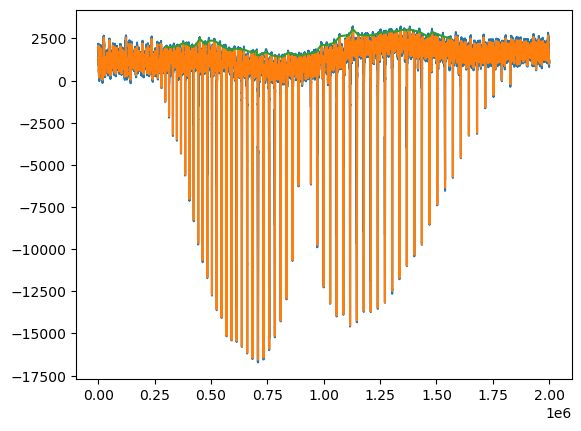

[[Model]]
    Model(lorentzian)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 49
    # data points      = 84
    # variables        = 3
    chi-square         = 7.5605e+13
    reduced chi-square = 9.3340e+11
    Akaike info crit   = 2318.16160
    Bayesian info crit = 2325.45405
[[Variables]]
    amplitude:  33222.5053 +/- 3056.24245 (9.20%) (init = 7919.553)
    center:     0.13259400 +/- 3.5449e-05 (0.03%) (init = 0.1323931)
    sigma:      0.00101672 +/- 6.7076e-05 (6.60%) (init = 0.0001910089)
    fwhm:       0.00203344 +/- 1.3415e-04 (6.60%) == '2.0000000*sigma'
    height:     10401148.7 +/- 428895.546 (4.12%) == '0.3183099*amplitude/max(1e-15, sigma)'
[[Correlations]] (unreported correlations are < 0.250)
    C(amplitude, center) = -0.957
    C(amplitude, sigma)  =  0.916
    C(center, sigma)     = -0.820


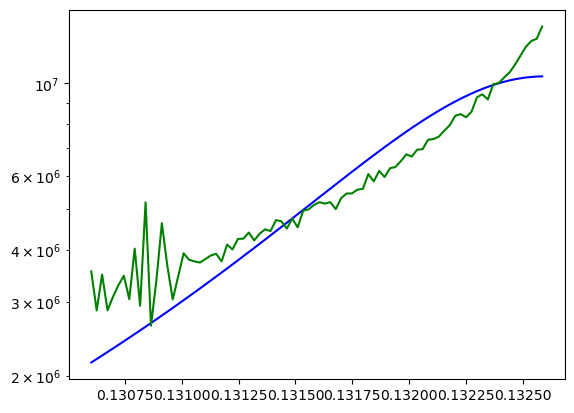

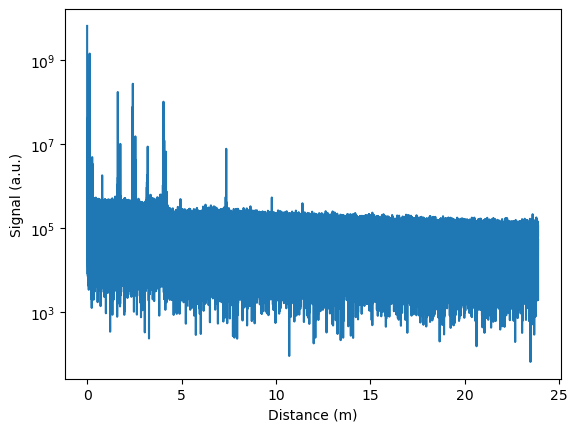

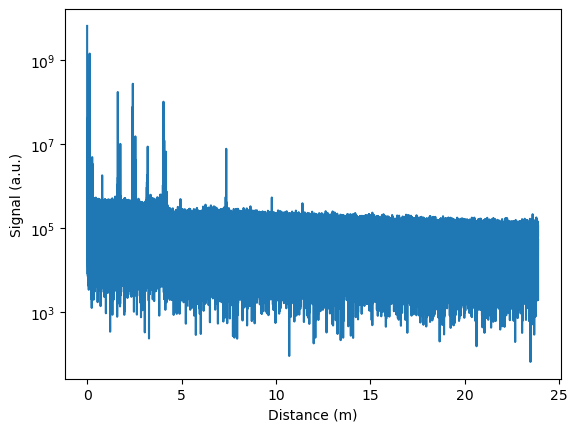

[0.132594]
{0: array([ 2150222.04272071,  2191656.88854006,  2234190.57257819,
        2277857.49944113,  2322693.15864691,  2368734.14573381,
        2416018.18172802,  2464584.13062277,  2514472.01447954,
        2565723.02571108,  2618379.53605427,  2672485.10167966,
        2728084.46382212,  2785223.54424294,  2843949.43475726,
        2904310.37997444,  2966355.75230475,  3030136.01818632,
        3095702.6943734 ,  3163108.29301021,  3232406.25408369,
        3303650.86371377,  3376897.15658963,  3452200.80070655,
        3529617.96239009,  3609205.14942467,  3691019.02991997,
        3775116.22436552,  3861553.0681323 ,  3950385.34149363,
        4041667.96404757,  4135454.65024585,  4231797.52256453,
        4330746.67870787,  4432349.70911258,  4536651.16093886,
        4643691.9446998 ,  4753508.67970549,  4866132.97460672,
        4981590.63951819,  5099900.82651889,  5221075.09577538,
        5345116.40515212,  5472018.02197022,  5601762.35659932,
        5734319.71882827,

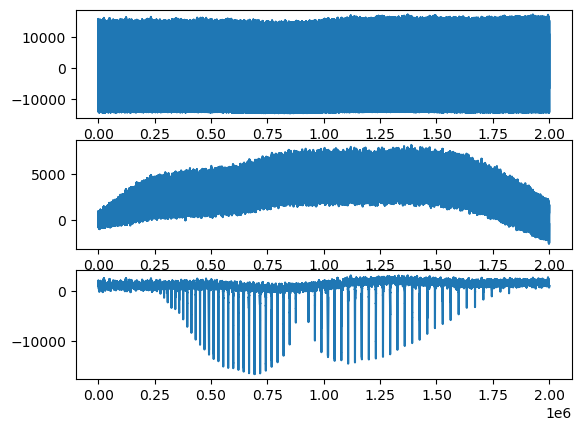

Butter  [ 0.99944479 -1.99888959  0.99944479] [ 1.         -1.99888928  0.9988899 ]
TInv  1.2500000000000001e-08
T_Simu
2000000
[0.00000000e+00 1.25000063e-08 2.50000125e-08 ... 2.49999750e-02
 2.49999875e-02 2.50000000e-02]


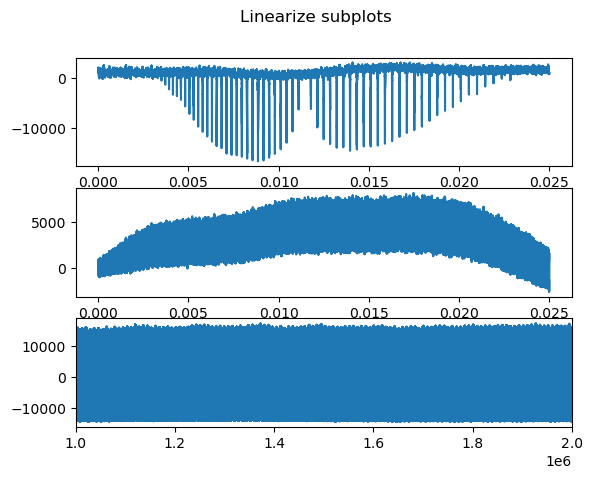

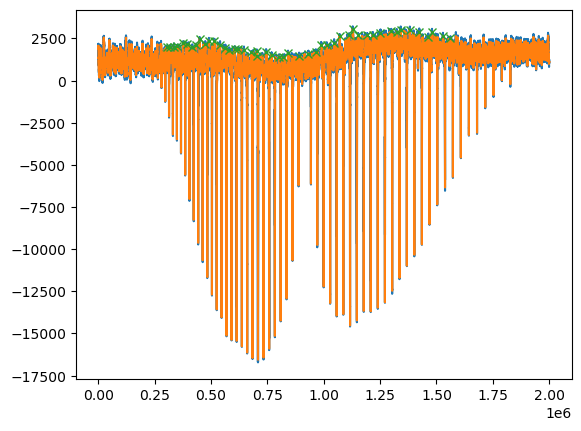

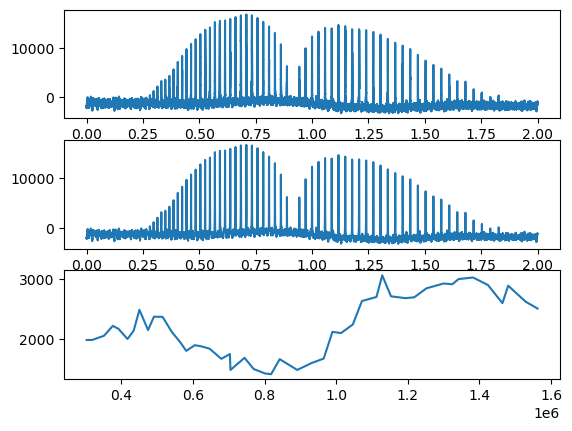

In [71]:
'Main Function for Linearization'

externalData = np.load('data/fsiDataForTomek.npy', allow_pickle=True)

rawData = { 
    'Measurement int'   : externalData[1], # Raw data from the measurement interferometer 
    'Gas cell'          : externalData[2],
    'Reference int'     : externalData[0],
    'Time interval'     : externalData[3]
}


class FsiSignalParams:
    def __init__(self, CHAN_NUM = 0, CURRENT_DISTANCE = 0.5, DISTANCE_WINDOW = 0.01, PICO_V_RANGE = PICO_RANGE.R200MV, ERROR_COUNTER = 0, FBG = False):
        self.distanceWindow    = DISTANCE_WINDOW    # Distance around center value for the fitting window 
        self.currentDistance   = CURRENT_DISTANCE   # Current value of distance measurement
        self.chanNumber        = CHAN_NUM           # Channel number
        self.picoRange         = PICO_V_RANGE       # Current voltage range of the PicoScope channel
        self.errorCounter      = ERROR_COUNTER      # Error counter
        self.fbg               = FBG                # Defines whether the channel is a Fiber Bragg Grating sensor of an FSI sensor (Boolean)


fsiParamsHandle = FsiSignalParams(2, [0.131594], 0.001, PICO_RANGE.R200MV, 0, False)

class GlobalConfig:
    setupOpMode         = SETUP_OP_MODE.NORMAL              # Setup operation mode
    resultsFileName     = 'Test.csv'                        # Name and path to the file where the measurement results are saved
    externalRawData     = 'Debug\\TestLabViewSecond.mat'    # Name and path to a file containing raw data for analysis (TEST_MODE only!)
    laserParams         = initCfg.LaserInitParams           # Laser configuration
    picoParams          = initCfg.PicoScopeInitParams       # PisoScope configuration
    edfaParams          = initCfg.EdfaInitParams            # EDFA configuration
    foSwitchParams      = initCfg.FoSwitchInitParams        # Fiber optic switch configuration
    photoModuleParams   = initCfg.PhotoModuleInitParams     # Photodetection module configuration
    computationConfig   = initCfg.ComputationConfig         # Configuration of the computation algorithm

    
zpf   = 1
nAir = 1.0

Tinterval = rawData['Time interval']
print(rawData['Time interval'])
print('Sampling rate: ' + str((1/rawData['Time interval'])/1e6) + ' MSPS') 
REF_IM = rawData['Reference int']

REF_IM = filterDataButterworthHighpass(rawData['Reference int'],100000,800000000)
start_time = time.time()
Gas_Linear, Meas_Linear =  DataLinearize(rawData['Time interval'], rawData['Reference int'], rawData['Gas cell'], rawData['Measurement int']) 

print("--- Time to Linearize %s seconds ---" % (time.time() - start_time))


print(Gas_Linear)

print(Meas_Linear)



'Gas Cell Peak Detection'
retStatus = {}

processedDataStorage = {}          #Dictionary to store output data

cLight      = 299792458                                 # Speed of light in m/s

processedDataStorage['Filtered gas cell out'] = savgol_filter(Gas_Linear, 101, 2, mode='mirror')  # Signal filtering - Savitzky-Golay filter
processedDataStorage['Gas cell peak idxs'], retStatus['Gas cell'] = gasCellFindPeaks(processedDataStorage['Filtered gas cell out'], GlobalConfig.picoParams, GlobalConfig.laserParams, 'pyfsi/SRM2519a.csv')  # Beta test

GAS_CELL_wavelengths = np.genfromtxt('SRM2519a.csv')                 # Load reference data for the gas cell used (NIST)
GAS_CELL_wavelengths = GAS_CELL_wavelengths*1e-9                            # Convert to m
GAS_CELL_spectrum = cLight/GAS_CELL_wavelengths                             # Convert reference spectral data to frequency
GAS_CELL_spectrum_time = processedDataStorage['Gas cell peak idxs']*rawData['Time interval']                  # Calculate peak occurence times in the measured gas cell signal
    
alpha = np.polyfit(GAS_CELL_spectrum_time, GAS_CELL_spectrum,1)             # Calculate the real sweep speed (linear fit)
alpha = alpha[0]


print(processedDataStorage['Gas cell peak idxs'])

plt.plot(Gas_Linear)
plt.plot(processedDataStorage['Filtered gas cell out'])
plt.plot(processedDataStorage['Gas cell peak idxs'], processedDataStorage['Filtered gas cell out'][processedDataStorage['Gas cell peak idxs']])
plt.show()



'Measured peak detection and distance'

processedDataStorage['FFT magnitude axis'] = abs(np.fft.rfft(Meas_Linear, int(len(Meas_Linear)+ (zpf-1)*len(Meas_Linear))))        # "Real" FFT, length includes padded zeros
f = np.fft.rfftfreq( int(len(Meas_Linear) + (zpf-1)*len(Meas_Linear)), d=rawData['Time interval'])        # Frequency axis calculation, length includes padded zeros
Meas_coef = cLight/(2*abs(alpha)*nAir)                                               # Frequency-to-distance calculation coefficient
processedDataStorage['FFT distance axis'] = Meas_coef*f          
processedDataStorage['FFT fit peaks distance'], processedDataStorage['FFT fit peaks magnitude'], processedDataStorage['Fitted distance values'], retStatus['Fft fit'] = fitFsiPeaks(processedDataStorage['FFT distance axis'], processedDataStorage['FFT magnitude axis'], fsiParamsHandle, GlobalConfig.setupOpMode, fullOutput=True)

print(processedDataStorage['Fitted distance values'])
print(processedDataStorage['FFT fit peaks magnitude'])
print(processedDataStorage['FFT fit peaks distance'])

print("--- Total execution time in %s seconds ---" % (time.time() - start_time))

'Plot Data'


'Raw Data Plots'
print('Tinterval: ' + str(rawData['Time interval']) + ' s')
fig1 = plt.figure()
plt.subplot(3, 1, 1)
plt.plot(rawData['Reference int'])
plt.subplot(3, 1, 2)
plt.plot(rawData['Measurement int'])
plt.subplot(3, 1, 3)
plt.plot(rawData['Gas cell'])
plt.show()

'Linearize plots'
Gas_Linear, Meas_Linear =  DataLinearize(rawData['Time interval'], rawData['Reference int'], rawData['Gas cell'], rawData['Measurement int']) 
REF_IM = rawData['Reference int']
x = np.arange(0,2000000, 1)
y = Gas_Linear
y2 = Meas_Linear
y3 = rawData['Reference int']
x3 = np.linspace(0.0, len(REF_IM)*Tinterval, num=len(REF_IM))

print(x3)
fig, (ax1, ax2, ax3) = plt.subplots(3)
fig.suptitle('Linearize subplots')
ax1.plot(x3, y)
ax2.plot(x3, y2)
ax3.plot(x, y3)

plt.xlim(1000000,2000000)

plt.show()


'Gas Cell Peak plots'

plt.plot(Gas_Linear)
plt.plot(processedDataStorage['Filtered gas cell out'])
plt.plot(processedDataStorage['Gas cell peak idxs'], processedDataStorage['Filtered gas cell out'][processedDataStorage['Gas cell peak idxs']], 'x')
plt.show()



fig2 = plt.figure()
plt.subplot(3,1,1)
plt.plot(-Gas_Linear)
plt.subplot(3,1,2)
plt.plot(-processedDataStorage['Filtered gas cell out'])
plt.subplot(3, 1, 3)
plt.plot(processedDataStorage['Gas cell peak idxs'], processedDataStorage['Filtered gas cell out'][processedDataStorage['Gas cell peak idxs']])
plt.show()




